# StyleGAN (Deprecated)
Pre-trained model of 256x256 image resolution provided.

There is a newer and faster version in `ch7_faster_stylegan.ipynb`. The core building blocks are remained the same. The difference is that it has been refactored to use Keras' custom train step hence run in graph mode (non-eager) and faster to train. The newer version also run with Tensorflow 2.5.0

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, Dense, Input, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Lambda
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.constraints import max_norm
from tensorflow_addons.layers import InstanceNormalization
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from glob import glob
from functools import partial
import time
import gdown
import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

Tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


# Download dataset

In [ ]:
url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" 
gdown.download(url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq

## Set image resolution to train, suggest to use 64 for slow GPU

In [3]:
IMAGE_RESOLUTION = 256

In [4]:
PATH = "celeba_hq/"
BUFFER_SIZE = 200
os.makedirs('./save_images', exist_ok=True)

def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image
        
train_datasets = {}
train_images = glob(PATH+'train/**/*.jpg')
random.shuffle(train_images)
train_dataset_list = tf.data.Dataset.from_tensor_slices(train_images)

n_workers = tf.data.experimental.AUTOTUNE
BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 4, 10:4}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}
for log2_res in range(2, int(np.log2(IMAGE_RESOLUTION))+1):
    res = 2**log2_res
    temp = train_dataset_list.map(partial(load, res),  num_parallel_calls= n_workers)

    temp = temp.shuffle(BUFFER_SIZE).batch(BATCH_SIZE[log2_res], drop_remainder=True).repeat()
    train_datasets[log2_res] = temp

In [5]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = scales[log2_res]
    
    grid_col = min(images.shape[0], int(16//scale))
    grid_row = 1
    #grid_row = images.shape[0]//grid_col
    #grid_row = min(2, grid_row)

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        print("image name", fname)
        f.savefig(fname)

In [6]:
class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)

class MinibatchStd(Layer): 
    def __init__(self, group_size=4, epsilon=1e-8): 

        super(MinibatchStd, self).__init__() 
        self.epsilon = epsilon 
        self.group_size = group_size 
        
    def call(self, input_tensor): 

        n, h, w, c = input_tensor.shape 
        x = tf.reshape(input_tensor, [self.group_size, -1, h, w, c]) 
        group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
        group_std = tf.sqrt(group_var + self.epsilon) 
        avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
        x = tf.tile(avg_std, [self.group_size, h, w, 1]) 

        return tf.concat([input_tensor, x], axis=-1) 
    
class FadeIn(Layer):
    @tf.function
    def call(self, input_alpha, a, b):
        alpha = tf.reduce_mean(input_alpha)
        y = alpha * a + (1. - alpha) * b
        return y
    
def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)



In [7]:
class Conv2D(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(Conv2D, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class Dense(Layer):
    def __init__(self, units, gain=2, lrmul=1, **kwargs):
        super(Dense, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.lrmul = lrmul
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1./self.lrmul)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function
    def call(self, inputs):
        output = tf.matmul(inputs, self.scale*self.w) + self.b
        return output*self.lrmul
    

In [8]:
class AddNoise(Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.B = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.B * noise
        return output

class AdaIN(Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = Dense(self.x_channels, gain=1)
        self.dense_2 = Dense(self.x_channels, gain=1)
        
        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

In [9]:
class StyleGAN():
    def __init__(self, z_dim=512, resolution=512, start_log2_res=2):
        self.start_log2_res = start_log2_res
        self.resolution = resolution
        self.log2_resolution = int(np.log2(resolution))
        self.log2_res_to_filter_size = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 

        self.z_dim = z_dim
        self.initializer = tf.keras.initializers.RandomNormal(0., 1.)
        self.opt_init = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

        self.g_loss = 0.
        self.d_loss = 0.
        self.build_mapping()
        self.build_all_generators()
        self.build_all_discriminators()
        
        # initialize generator with the base
        self.alpha = np.array([[1]], dtype=np.float32)
        dummy_alpha = Input(shape=(1), name='DummyAlpha')    
        input_const = Input(shape=(4,4,512), name='ConstInput')
        w = Input(shape=(8, 512))
        
        output = self.generator_blocks[2]([input_const, 
                                          w[:,0],
                                          self.noise_inputs[2]])
        rgb = self.to_rgb[2](output)
        self.generator = Model([input_const, 
                                w,
                                dummy_alpha,
                                self.noise_inputs], rgb)

        # build base discriminator
        input_image = Input(shape=(4,4,3))
        alpha = Input(shape=(1))           
        x = self.from_rgb[2](input_image)  
        pred = self.discriminator_blocks[2](x)

        self.discriminator = Model([input_image, alpha], pred,
                                    name='discriminator_4x4')

        self.optimizer_discriminator = Adam(**self.opt_init)                

        self.discriminator.trainable = False

        # build composite model
        pred = self.discriminator([self.generator.output, 
                                   self.generator.input[2]])

        self.model = Model(inputs=[self.generator.input],
                          outputs=pred)
        self.model.compile(loss=wasserstein_loss, optimizer=Adam(**self.opt_init))

        self.ckpt_path = f"./checkpoints/stylegan/"
        
                    
    def build_all_generators(self):

        # build all the generator block
        self.to_rgb = {}
        self.generator_blocks = {}
        self.noise_inputs = {}
        self.w_inputs = {}
        
        for log2_res in range(2, self.log2_resolution+1):
            res = 2**log2_res
            self.noise_inputs[log2_res] = Input(shape=(res, res, 1), name=f'noise_{res}x{res}')
            self.w_inputs[log2_res] = Input(shape=(512))
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.to_rgb[log2_res] = self.build_to_rgb(res, filter_n)
            if log2_res == 2:
                input_shape = (4, 4, 512)
            else:
                input_shape = self.generator_blocks[log2_res-1].output[0].shape
            gen_block = self.build_generator_block(log2_res, input_shape)
            self.generator_blocks[log2_res] = gen_block
            
            
    def build_mapping(self):
        # Mapping Network
        z = Input(shape=(self.z_dim))
        w = PixelNorm()(z)
        for i in range(8):
            w = Dense(512, lrmul=0.01)(w)
            w = LeakyReLU(0.2)(w)
        
        w = tf.tile(tf.expand_dims(w, 1), (1,8,1))            
        self.mapping = Model(z, w, name='mapping')
        
    def build_generator_block(self, log2_res, input_shape):
        res = int(2**log2_res)
        res_name = f'{res}x{res}'
        filter_n = self.log2_res_to_filter_size[log2_res]

        input_tensor = Input(shape=input_shape)
        x = input_tensor
        
        w = Input(shape=512)
        noise = Input(shape=(res, res, 1))

        if log2_res > 2:
            x = UpSampling2D((2,2))(x)
            x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv1')(x)

        x = AddNoise()([x, noise])
        x = LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        
        # ADD NOISE
        x = Conv2D(filter_n, 3, name=f'gen_{res_name}_conv2')(x)
        x = AddNoise()([x, noise])    
        x = LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)      
        x = AdaIN()([x, w])

        return Model([input_tensor, 
                      w, 
                      noise
                     ], x, 
                     name=f'genblock_{res}_x_{res}') 


        
    def build_discriminator_block(self, log2_res, input_shape):

        filter_n = self.log2_res_to_filter_size[log2_res]        
        input_tensor = Input(shape=input_shape)
        
        # First conv
        x = Conv2D(filter_n, 3)(input_tensor)
        x = LeakyReLU(0.2)(x)
        
        # Second conv + downsample
        filter_n = self.log2_res_to_filter_size[log2_res-1]        
        x = Conv2D(filter_n, 3,)(x)
        x = LeakyReLU(0.2)(x)
        x = AveragePooling2D((2,2))(x)
        
        res = 2**log2_res
        return Model(input_tensor, x, 
                     name=f'disc_block_{res}_x_{res}') 
        
        
    def build_discriminator_base(self, input_shape):

        input_tensor = Input(shape=input_shape)

        x = MinibatchStd()(input_tensor)

        x = Conv2D(512, 3, name='gen_4x4_conv1')(x)
        x = LeakyReLU(0.2)(x)
        x = Flatten()(x)
        
        x = Dense(512, name='gen_4x4_dense1')(x)
        x = LeakyReLU(0.2)(x)

        x = Dense(1, name='gen_4x4_dense2')(x)
        
        return Model(input_tensor, x, 
                     name='discriminator_base') 

    def build_to_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, filter_n)),
                           Conv2D(3, 1, gain=1, activation=None,
                                  name=f'to_rgb_{res}x{res}_conv')],
                         name=f'to_rgb_{res}x{res}')
    
    def build_from_rgb(self, res, filter_n):
        
        return Sequential([Input(shape=(res, res, 3)),
                           Conv2D(filter_n, 1,
                                  name=f'from_rgb_{res}x{res}_conv'),
                           LeakyReLU(0.2)],
                         name=f'from_rgb_{res}x{res}')
    
    def build_all_discriminators(self):
        
        self.from_rgb = {}
        self.discriminator_blocks = {}
        
        # all but the final block
        for log2_res in range(self.log2_resolution, 1, -1):
            res = 2**log2_res
            filter_n = self.log2_res_to_filter_size[log2_res]            
            self.from_rgb[log2_res] = self.build_from_rgb(res, filter_n)
            
            input_shape = (res, res, filter_n)
            self.discriminator_blocks[log2_res] = self.build_discriminator_block(log2_res, input_shape)

        # last block at 4x4 resolution
        log2_res = 2
        filter_n = self.log2_res_to_filter_size[log2_res]            
        self.from_rgb[log2_res] = self.build_from_rgb(4, filter_n)
        res = 2**log2_res
        input_shape = (res, res, filter_n)            
        self.discriminator_blocks[log2_res] = self.build_discriminator_base(input_shape)
                                       
        
    def grow_discriminator(self, log2_res):
        res = 2**log2_res 

        input_image = Input(shape=(res, res, 3))
        alpha = Input(shape=(1))
        
        x = self.from_rgb[log2_res](input_image)
        x = self.discriminator_blocks[log2_res](x)        
        
        downsized_image = AveragePooling2D((2,2))(input_image)
        y = self.from_rgb[log2_res-1](downsized_image)
        
        x = FadeIn()(alpha, x, y)
        for i in range (log2_res-1, 1, -1):
            x = self.discriminator_blocks[i](x)
            
        self.discriminator =  Model([input_image, alpha], x,
                     name=f'discriminator_{res}_x_{res}')
        
        self.optimizer_discriminator = Adam(**self.opt_init)        
                
    def grow_generator(self, log2_res):
        res = 2**log2_res
        alpha = Input(shape=(1))
        
        w = Input(shape=(9, 512))
        input_const = Input(shape=(4,4,512))
        
        x = self.generator_blocks[2]([input_const, 
                                          w[:,0],
                                          self.noise_inputs[2]])
        
        #print(f"grow_generator start, log2={2} w={0}, noise={2}", )
        
        for i in range(3, log2_res):
            
            x = self.generator_blocks[i]([x, 
                                          w[:,i-2], 
                                          self.noise_inputs[i]])
            print(f"grow_generator mid, log2={i} w={i-2}, noise={i}", )
        
        old_rgb = self.to_rgb[log2_res-1](x)
        old_rgb = UpSampling2D((2,2))(old_rgb)
        
        x = self.generator_blocks[log2_res]([x, 
                                             w[:,log2_res-2],
                                             self.noise_inputs[log2_res]])
        print(f"grow_generator end, log2={log2_res} w={log2_res-2}, noise={log2_res}", )
        
        new_rgb = self.to_rgb[log2_res](x)
        rgb = FadeIn()(alpha, new_rgb, old_rgb)
        
        self.generator = Model([input_const,
                                w,
                                alpha,
                                self.noise_inputs], 
                                rgb, 
                        name=f'generator_{res}_x_{res}')         
                         
    def grow_model(self, log2_res):
        tf.keras.backend.clear_session()
        res = 2**log2_res
        print(f"Growing model to {res}x{res}")
    
        self.grow_generator(log2_res)
        self.grow_discriminator(log2_res)

        self.discriminator.trainable = False

        pred = self.discriminator([self.generator.output, 
                                   self.generator.input[2]])

        self.model = Model(inputs=self.generator.input,
                          outputs=pred)
        
        self.model.compile(loss=wasserstein_loss, 
                           optimizer=Adam(**self.opt_init))
    
    def train_discriminator_wgan_gp(self, real_images, alpha):
        
        batch_size = real_images.shape[0]
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))        
        w = self.mapping(z)
        fake_images = self.generator([const_input, w, alpha, noise])
        
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = 0.001 * tf.reduce_mean(all_pred**2)
            
            total_loss = loss_fake + loss_real + gradient_penalty + drift_loss
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.discriminator.variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.variables))


        return total_loss
    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(2, self.log2_resolution+1)]
        return noise
    
    def train_step(self,  log2_res, data_gen, alpha):
        real_images = next(data_gen)
        self.d_loss = self.train_discriminator_wgan_gp(real_images, alpha)

        real_images = next(data_gen)
        batch_size = real_images.shape[0]
        real_labels = tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        w = self.mapping(z)
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        self.g_loss = self.model.train_on_batch([const_input, w, alpha, noise], 
                                                real_labels)

    
    def generate(self, z):
        batch_size = z.shape[0]
        const_input = tf.ones((batch_size, 4, 4, 512))        
        noise = self.generate_noise(batch_size)
        w = self.mapping(z)
        images = self.generator([const_input, w, self.alpha, noise])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255)
        return images.astype(np.uint8)
        
        
    def checkpoint(self, z, log2_res, step):
        res = 2**log2_res
        prefix = f'res_{res}x{res}_{step}'

        path = os.path.join(self.ckpt_path, prefix)
        print('Saving checkpoint',path)
        self.mapping.save(f'{path}/mapping')
        for i in range(2, log2_res+1):
            self.to_rgb[i].save(f'{path}/to_rgb_{i}')
            self.from_rgb[i].save(f'{path}/from_rgb_{i}')
            self.discriminator_blocks[i].save(f'{path}/d_{i}')
            self.generator_blocks[i].save(f'{path}/g_{i}')
        
        images = self.generate(z)
        plot_images(images, log2_res, f"./save_images/{prefix}.jpg")
        
    def load_checkpoint(self, path):
        self.mapping= tf.keras.models.load_model(f'{path}/mapping')
        max_log2res = int(max([os.path.basename(d).split('_')[-1] for d in glob(path+'/d_*')]))
        for i in range(2, max_log2res+1):
            self.to_rgb[i]= tf.keras.models.load_model(f'{path}/to_rgb_{i}')
            self.from_rgb[i]= tf.keras.models.load_model(f'{path}/from_rgb_{i}')
            self.discriminator_blocks[i]= tf.keras.models.load_model(f'{path}/d_{i}')
            self.generator_blocks[i]= tf.keras.models.load_model(f'{path}/g_{i}')
        
        self.grow_model(max_log2res)
        self.start_log2_res = max_log2res
        
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        self.penalty_const = 10
        loss = self.penalty_const * loss
        return loss
    
    def train(self, datasets, steps_per_phase = 1000, tick_interval=500):
        self.val_z = tf.random.normal((12, self.z_dim))
        
        for log2_res in range(self.start_log2_res, self.log2_resolution+1, 1):
            start_time = time.time()
            self.current_log2_res = log2_res
            
            res = 2**log2_res
            data_gen = iter(datasets[log2_res])
            print(f"Resolution {res}x{res}")
            
            for state in ['TRANSITION','STABLE']:
                if state == 'TRANSITION' and log2_res == 2:
                    continue
                
                steps = int(TRAIN_STEP_RATIO[log2_res] * steps_per_phase)
                interval = int(TRAIN_STEP_RATIO[log2_res] * tick_interval)
                for step in range(0, steps):
                    alpha = step/steps if state == 'TRANSITION' else 1.
                    self.alpha = np.array([[alpha]])

                    if step%interval == 0:                        
                        #print('alpha', self.alpha)
                        elapsed = time.time() - start_time
                        start_time = time.time()
                        minutes = int(elapsed//60)
                        seconds = int(elapsed%60)
                        print(f"elapsed {minutes} min {seconds} sec")
                        msg = f"{state}. Resolution {res}x{res} Step {step}: g_loss {self.g_loss:.4f} d_loss {self.d_loss:.4f}"
                        print(msg)

                        self.checkpoint(self.val_z, log2_res, step)

                    self.train_step(log2_res, data_gen, self.alpha)
                        
            if log2_res != self.log2_resolution:
                self.grow_model(log2_res+1)
            
gan = StyleGAN(resolution=IMAGE_RESOLUTION)

## Training. You can skip this step to load pretrained model

Resolution 4x4
elapsed 0 min 0 sec
STABLE. Resolution 4x4 Step 0: g_loss 0.0000 d_loss 0.0000
Saving checkpoint ./checkpoints/stylegan/ckpt-1


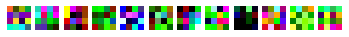

image name ./save_images/res_4x4_0.jpg
elapsed 5 min 16 sec
STABLE. Resolution 4x4 Step 5000: g_loss 1.9508 d_loss -3.3047
Saving checkpoint ./checkpoints/stylegan/ckpt-2


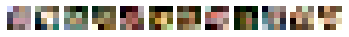

image name ./save_images/res_4x4_5000.jpg
Growing model to 8x8
grow_generator end, log2=3 w=1, noise=3
Resolution 8x8
elapsed 0 min 0 sec
TRANSITION. Resolution 8x8 Step 0: g_loss 2.8991 d_loss -4.0741
Saving checkpoint ./checkpoints/stylegan/ckpt-3


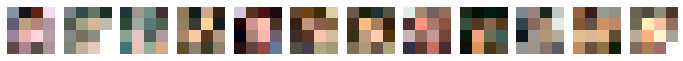

image name ./save_images/res_8x8_0.jpg
elapsed 8 min 16 sec
TRANSITION. Resolution 8x8 Step 5000: g_loss 5.4382 d_loss -8.1917
Saving checkpoint ./checkpoints/stylegan/ckpt-4


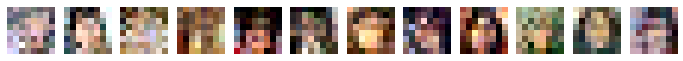

image name ./save_images/res_8x8_5000.jpg
elapsed 8 min 14 sec
STABLE. Resolution 8x8 Step 0: g_loss 1.1320 d_loss -8.4212
Saving checkpoint ./checkpoints/stylegan/ckpt-5


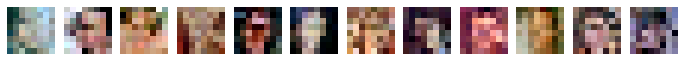

image name ./save_images/res_8x8_0.jpg
elapsed 8 min 15 sec
STABLE. Resolution 8x8 Step 5000: g_loss 2.2774 d_loss -6.4634
Saving checkpoint ./checkpoints/stylegan/ckpt-6


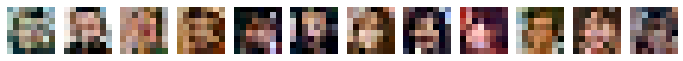

image name ./save_images/res_8x8_5000.jpg
Growing model to 16x16
grow_generator mid, log2=3 w=1, noise=3
grow_generator end, log2=4 w=2, noise=4
Resolution 16x16
elapsed 0 min 0 sec
TRANSITION. Resolution 16x16 Step 0: g_loss 2.5625 d_loss -6.4557
Saving checkpoint ./checkpoints/stylegan/ckpt-7


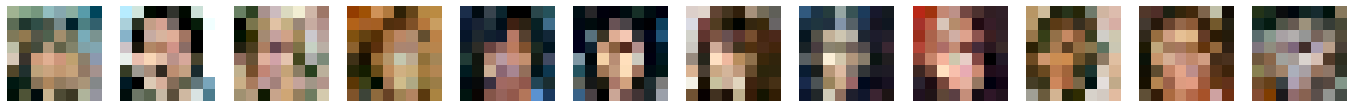

image name ./save_images/res_16x16_0.jpg
elapsed 12 min 10 sec
TRANSITION. Resolution 16x16 Step 5000: g_loss 12.1748 d_loss -13.2897
Saving checkpoint ./checkpoints/stylegan/ckpt-8


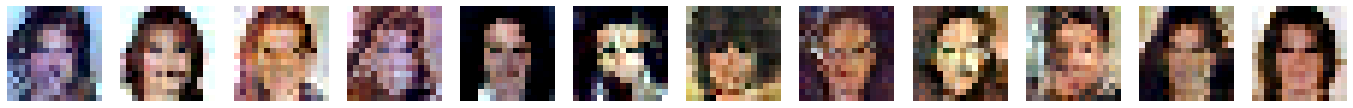

image name ./save_images/res_16x16_5000.jpg
elapsed 12 min 9 sec
STABLE. Resolution 16x16 Step 0: g_loss -5.6851 d_loss -12.8239
Saving checkpoint ./checkpoints/stylegan/ckpt-9


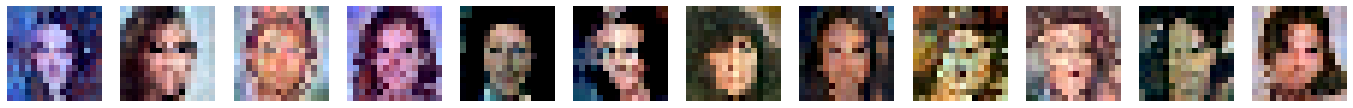

image name ./save_images/res_16x16_0.jpg
elapsed 12 min 9 sec
STABLE. Resolution 16x16 Step 5000: g_loss 0.8819 d_loss -7.6884
Saving checkpoint ./checkpoints/stylegan/ckpt-10


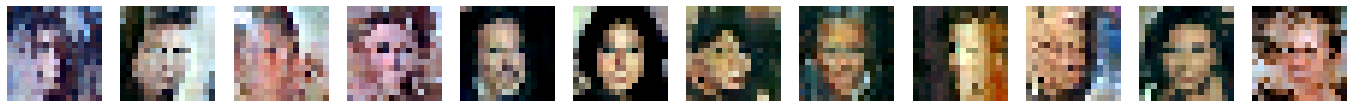

image name ./save_images/res_16x16_5000.jpg
Growing model to 32x32
grow_generator mid, log2=3 w=1, noise=3
grow_generator mid, log2=4 w=2, noise=4
grow_generator end, log2=5 w=3, noise=5
Resolution 32x32
elapsed 0 min 0 sec
TRANSITION. Resolution 32x32 Step 0: g_loss 5.4867 d_loss -2.6001
Saving checkpoint ./checkpoints/stylegan/ckpt-11


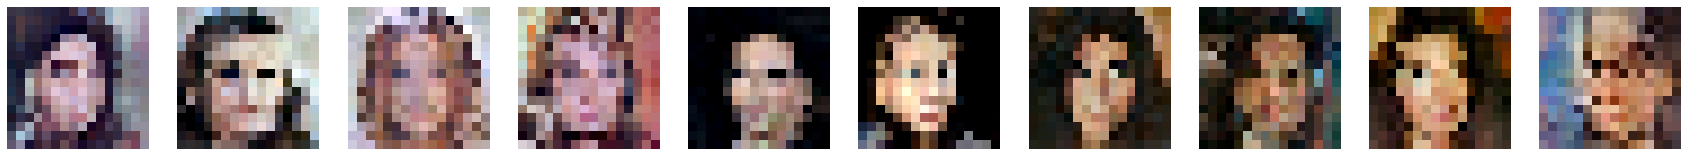

image name ./save_images/res_32x32_0.jpg
elapsed 23 min 3 sec
TRANSITION. Resolution 32x32 Step 5000: g_loss 19.3163 d_loss -16.5204
Saving checkpoint ./checkpoints/stylegan/ckpt-12


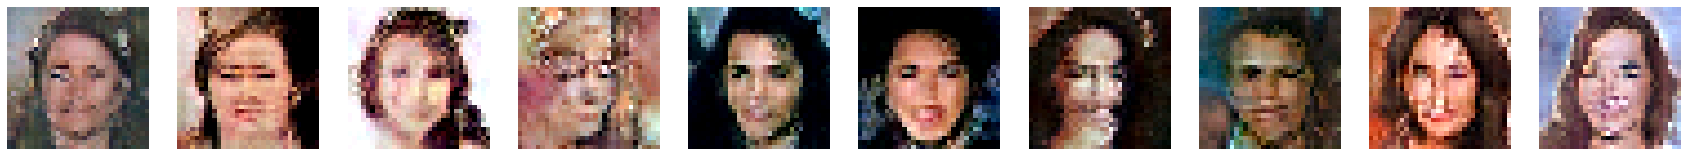

image name ./save_images/res_32x32_5000.jpg
elapsed 23 min 1 sec
STABLE. Resolution 32x32 Step 0: g_loss -28.9403 d_loss -15.5577
Saving checkpoint ./checkpoints/stylegan/ckpt-13


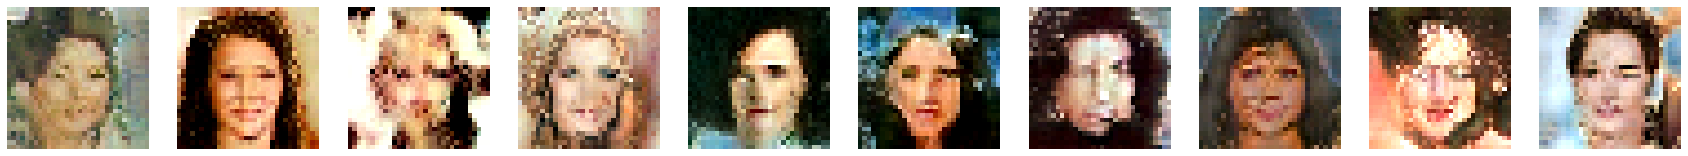

image name ./save_images/res_32x32_0.jpg
elapsed 23 min 1 sec
STABLE. Resolution 32x32 Step 5000: g_loss 21.9172 d_loss -13.4542
Saving checkpoint ./checkpoints/stylegan/ckpt-14


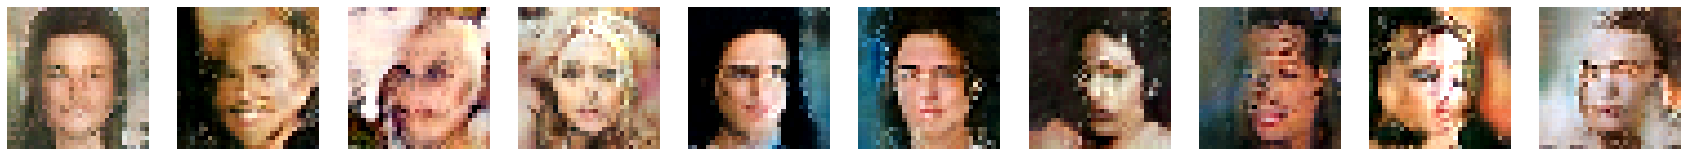

image name ./save_images/res_32x32_5000.jpg
Growing model to 64x64
grow_generator mid, log2=3 w=1, noise=3
grow_generator mid, log2=4 w=2, noise=4
grow_generator mid, log2=5 w=3, noise=5
grow_generator end, log2=6 w=4, noise=6
Resolution 64x64
elapsed 0 min 0 sec
TRANSITION. Resolution 64x64 Step 0: g_loss -5.9882 d_loss -4.1966
Saving checkpoint ./checkpoints/stylegan/ckpt-15


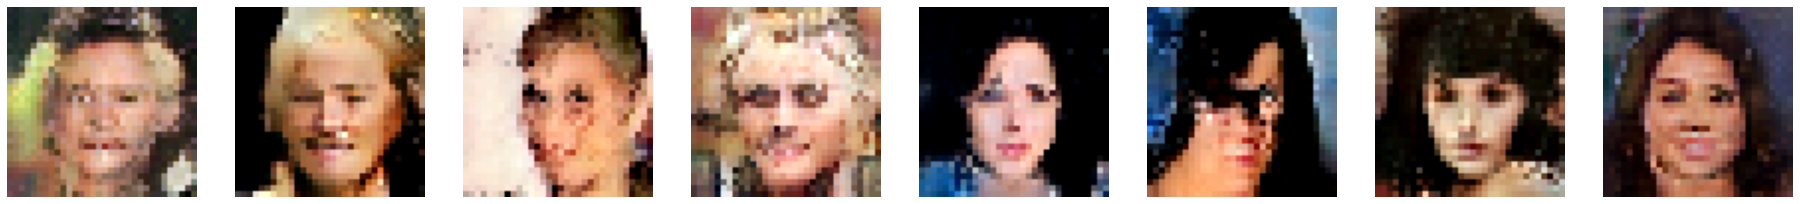

image name ./save_images/res_64x64_0.jpg
elapsed 45 min 3 sec
TRANSITION. Resolution 64x64 Step 5000: g_loss -3.6892 d_loss -11.7284
Saving checkpoint ./checkpoints/stylegan/ckpt-16


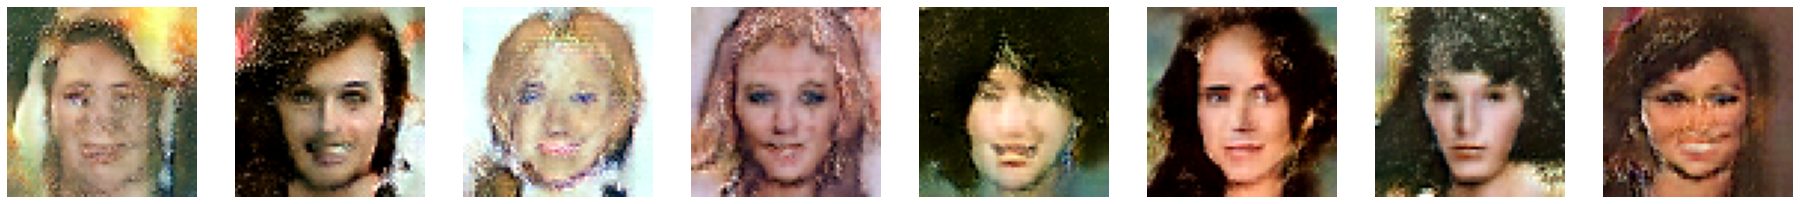

image name ./save_images/res_64x64_5000.jpg
elapsed 44 min 59 sec
STABLE. Resolution 64x64 Step 0: g_loss 48.5648 d_loss -31.5616
Saving checkpoint ./checkpoints/stylegan/ckpt-17


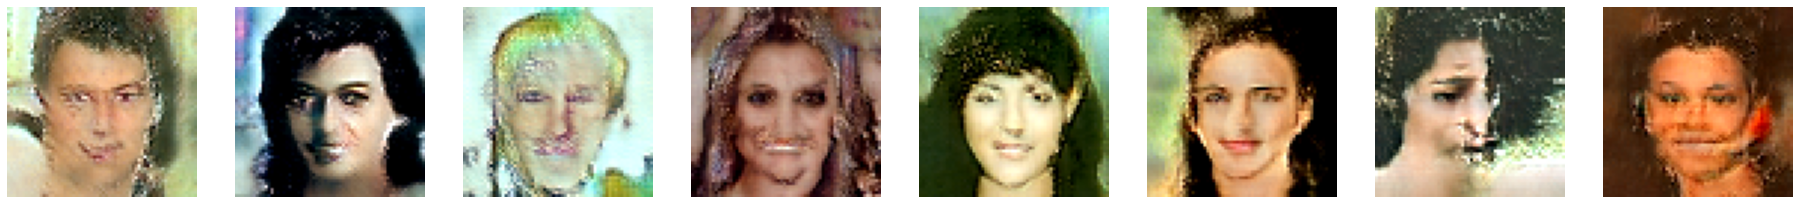

image name ./save_images/res_64x64_0.jpg
elapsed 44 min 59 sec
STABLE. Resolution 64x64 Step 5000: g_loss 56.9443 d_loss -21.8444
Saving checkpoint ./checkpoints/stylegan/ckpt-18


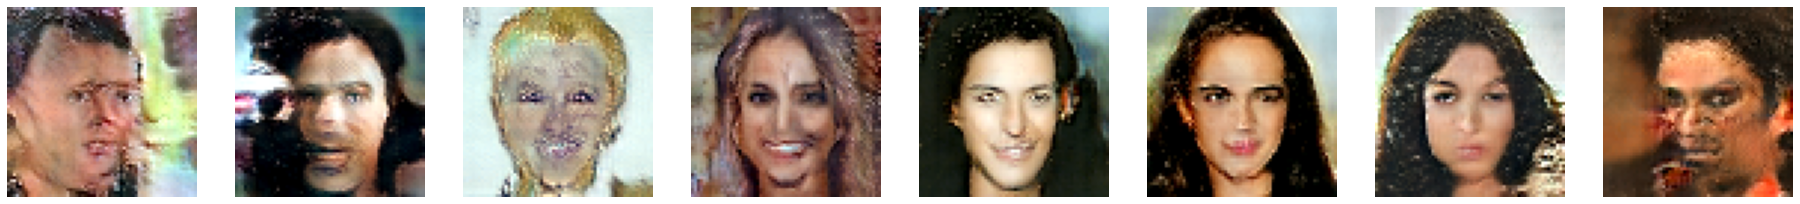

image name ./save_images/res_64x64_5000.jpg
Growing model to 128x128
grow_generator mid, log2=3 w=1, noise=3
grow_generator mid, log2=4 w=2, noise=4
grow_generator mid, log2=5 w=3, noise=5
grow_generator mid, log2=6 w=4, noise=6
grow_generator end, log2=7 w=5, noise=7
Resolution 128x128
elapsed 0 min 0 sec
TRANSITION. Resolution 128x128 Step 0: g_loss 20.2313 d_loss -24.0178
Saving checkpoint ./checkpoints/stylegan/ckpt-19


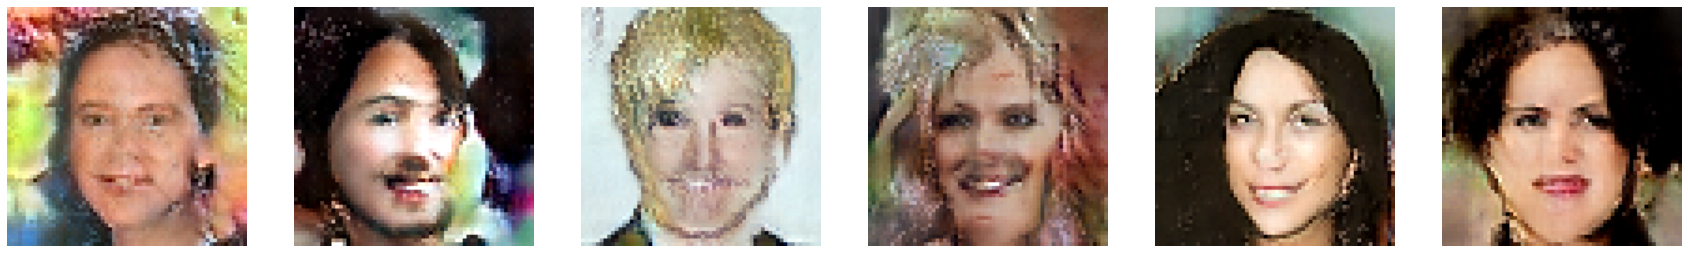

image name ./save_images/res_128x128_0.jpg
elapsed 104 min 45 sec
TRANSITION. Resolution 128x128 Step 10000: g_loss 40.4557 d_loss -42.3234
Saving checkpoint ./checkpoints/stylegan/ckpt-20


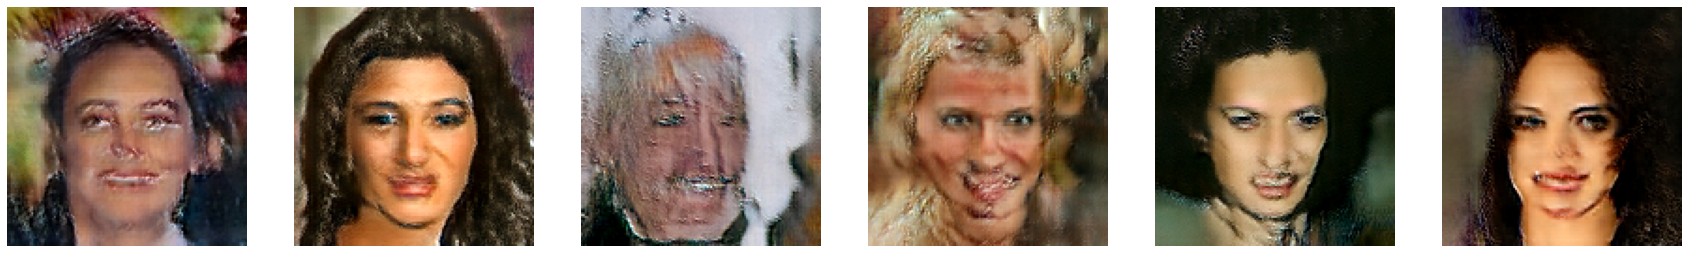

image name ./save_images/res_128x128_10000.jpg
elapsed 104 min 38 sec
STABLE. Resolution 128x128 Step 0: g_loss -38.2705 d_loss -37.3270
Saving checkpoint ./checkpoints/stylegan/ckpt-21


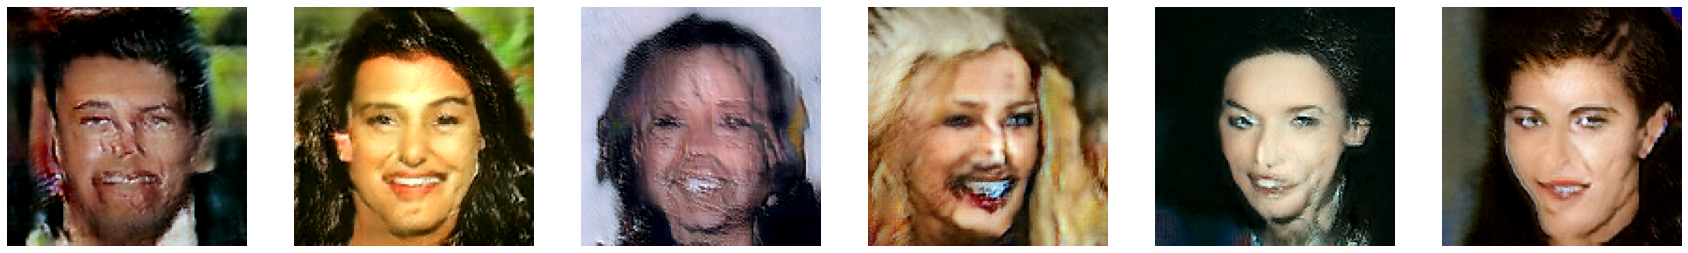

image name ./save_images/res_128x128_0.jpg
elapsed 104 min 40 sec
STABLE. Resolution 128x128 Step 10000: g_loss 4.9276 d_loss -38.7777
Saving checkpoint ./checkpoints/stylegan/ckpt-22


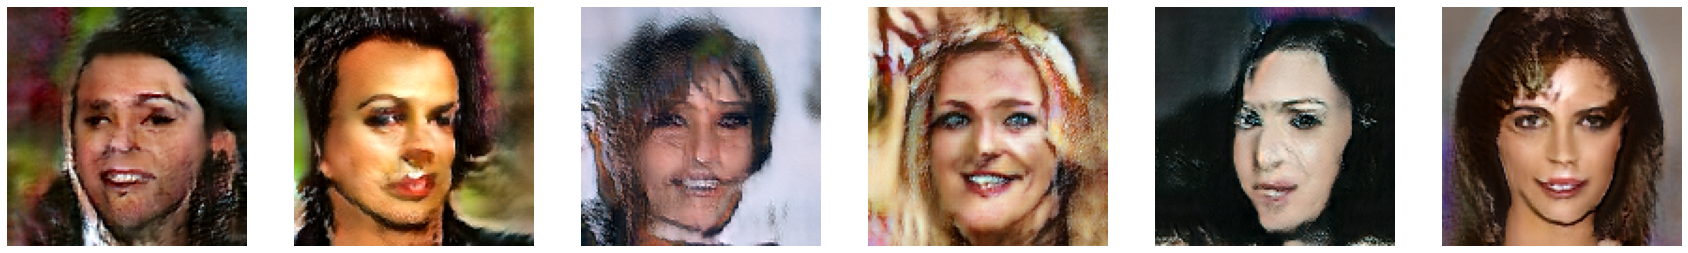

image name ./save_images/res_128x128_10000.jpg
Growing model to 256x256
grow_generator mid, log2=3 w=1, noise=3
grow_generator mid, log2=4 w=2, noise=4
grow_generator mid, log2=5 w=3, noise=5
grow_generator mid, log2=6 w=4, noise=6
grow_generator mid, log2=7 w=5, noise=7
grow_generator end, log2=8 w=6, noise=8
Resolution 256x256
elapsed 0 min 0 sec
TRANSITION. Resolution 256x256 Step 0: g_loss -2.1079 d_loss -38.7556
Saving checkpoint ./checkpoints/stylegan/ckpt-23


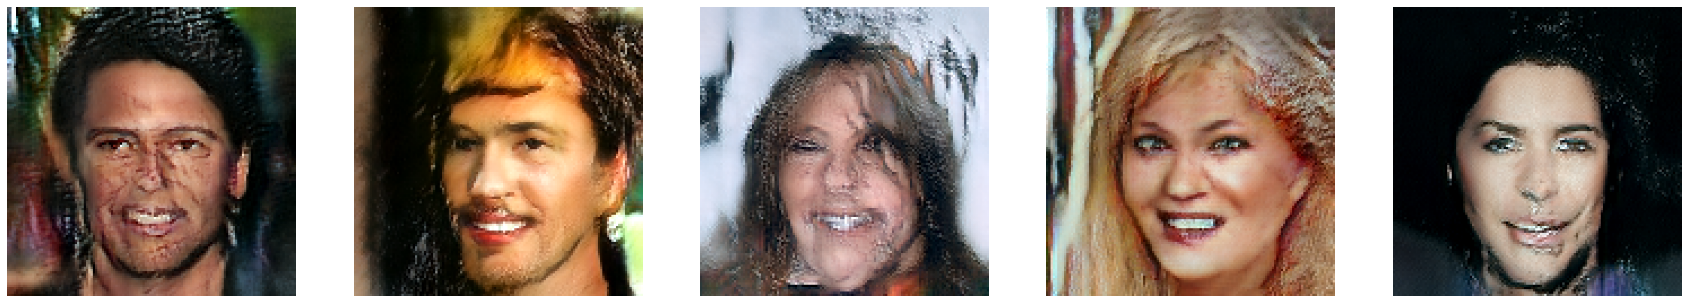

image name ./save_images/res_256x256_0.jpg
elapsed 196 min 20 sec
TRANSITION. Resolution 256x256 Step 20000: g_loss -13.2490 d_loss -61.6330
Saving checkpoint ./checkpoints/stylegan/ckpt-24


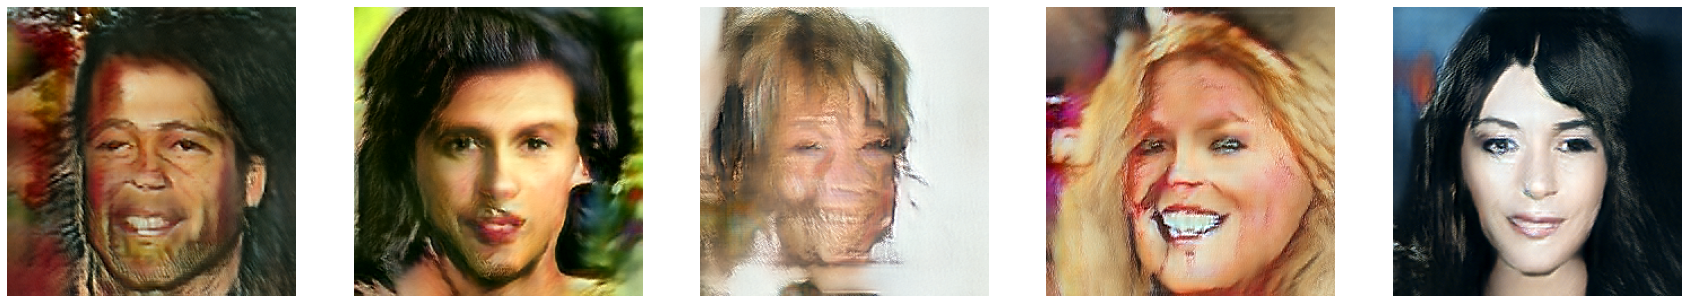

image name ./save_images/res_256x256_20000.jpg
elapsed 196 min 20 sec
STABLE. Resolution 256x256 Step 0: g_loss 24.1904 d_loss -94.9417
Saving checkpoint ./checkpoints/stylegan/ckpt-25


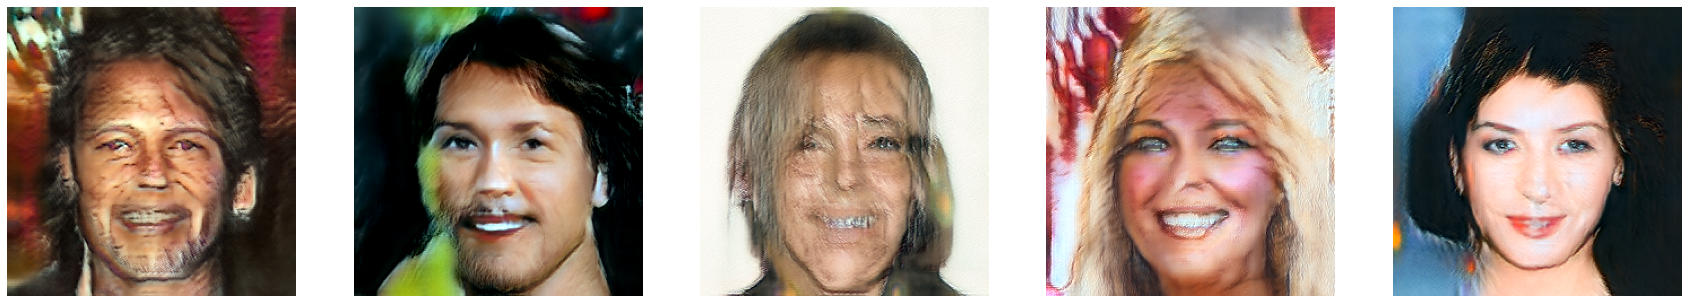

image name ./save_images/res_256x256_0.jpg


In [ ]:
gan.train(train_datasets, 10000, 5000)

# Uncomment to download and load pre-trained model

In [ ]:
# Download models
'''
url = 'https://drive.google.com/uc?id=1Dx8d_ZDQ4x_XxLmgDWdcxYuPBAZnP8Ou'
gdown.download(url, 'checkpoints.zip', quiet=False)
!unzip checkpoints.zip -d .
'''

In [17]:
# Load models
'''
path='./checkpoints/stylegan'
gan.load_checkpoint(path)
'''

# Generate Images

In [23]:
def generate_image(w, noise):
    const_input = tf.ones((1,4,4,512))
    w = tf.expand_dims(w, 0)
    #noise = tf.expand_dims(noise, 0)
    alpha = np.array([[1.]])
    images = gan.generator([const_input, w, alpha, noise])
    images = np.clip((images*0.5 + 0.5)*255, 0, 255)
    return images.astype(np.uint8)

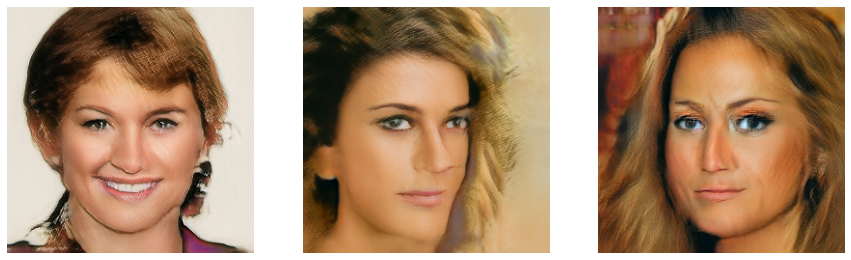

In [26]:
batch_size = 8
z = tf.random.truncated_normal((batch_size, 512))
w = gan.mapping(z)
noise = gan.generate_noise(batch_size)
images = gan.generate(z)
plot_images(images, 7)

# Style Mixing

In [72]:
# Select style from above
w_a = w[4]
w_b = w[5]

noise_a = gan.generate_noise(batch_size)
image_a = generate_image(w_a, noise_a)[0]
noise_b = gan.generate_noise(batch_size)
image_b = generate_image(w_b, noise_b)[0]


In [81]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


@interact
def explore_latent_variable(w0 = (0,1.0,0.05),
                            w1 = (0,1.0,0.05),
                            w2 = (0,1.0,0.05),
                            w3 = (0,1.0,0.05),
                            #w4 = (0,1.0,0.05),
                            #w5 = (0,1.0,0.05),
                            #w6 = (0,1.0,0.05),
                            #w7 = (0,1.0,0.05),
                            noise_src = widgets.Select(options=['Left', 'Right'], value='Left', 
                                                       description='Pose from:')
):
    w4 = w5 = w6 = w7 = 0.5
    w_mix = [w0*w_a[0]+(1-w0)*w_b[0],
             w1*w_a[1]+(1-w1)*w_b[1],
             w2*w_a[2]+(1-w2)*w_b[2],
             w3*w_a[3]+(1-w3)*w_b[3],
             w4*w_a[4]+(1-w4)*w_b[4],
             w5*w_a[5]+(1-w5)*w_b[5],
             w6*w_a[6]+(1-w6)*w_b[6],
             w7*w_a[7]+(1-w7)*w_b[7],
            ]
    noise = noise_a if noise_src == 'Right' else noise_b
    image_mix = generate_image(w_mix, noise)[0]
    images = np.stack([image_b, image_a, image_mix], axis=0)
    plot_images(images, 7)
    


interactive(children=(FloatSlider(value=0.5, description='w0', max=1.0, step=0.05), FloatSlider(value=0.5, des…

## Same Style, Different Noise

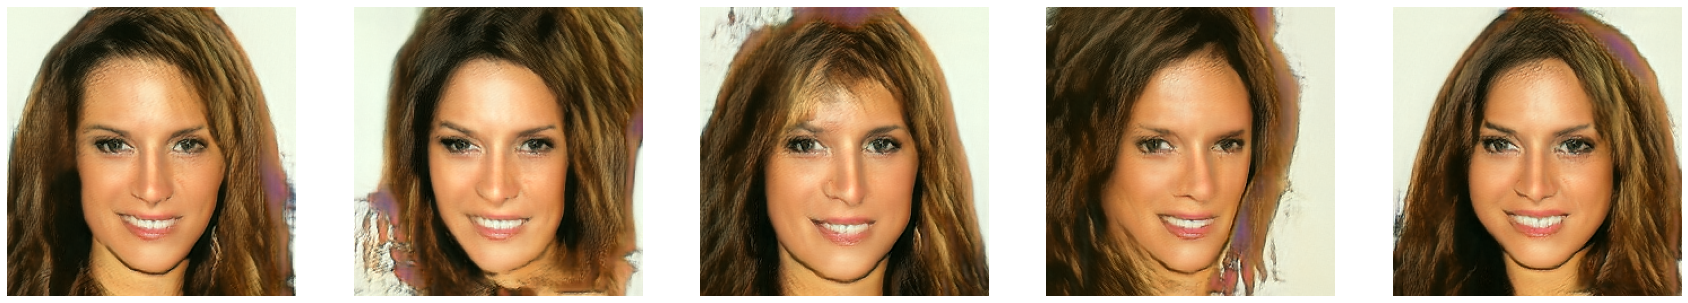

In [84]:
noise = gan.generate_noise(batch_size)
images = generate_image(w[5], noise)
plot_images(images, 8)

In [ ]:
tf.keras.utils.plot_model(gan.discriminator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.generator, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(gan.model, show_shapes=True)